<h1 style="color:magenta">Titanic Workshop ⛵</h1>

In [1]:
#cargamos las librerias
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
#leer los datos
df_train = pd.read_csv('C:/Users/57313/Documents/Python Scripts/train.csv')
df_test = pd.read_csv('C:/Users/57313/Documents/Python Scripts/test.csv')


In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [5]:
df_train.shape

(891, 12)

In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292



## Análisis de los datos


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
#nulos
total = df_train.isnull().sum().sort_values(ascending = False)
total

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [9]:
#Esta función toma un DataFrame (df) como entrada y devuelve dos columnas, valores nulos totales y porcentaje de valores nulos totales
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [10]:
missing_percentage(df_train)

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00


## Algunas observaciones:
- Hay un total de 891 pasajeros en nuestro conjunto de entrenamiento.
- A la característica Edad le falta aproximadamente el 19,8% de sus valores. Supongo que la función Edad es bastante importante para la supervivencia, por lo que probablemente deberíamos intentar llenar estos vacíos.
- A la característica de cabina le falta aproximadamente el 77,1% de sus valores. Dado que falta una gran parte de la función, sería difícil completar los valores que faltan. Probablemente eliminaremos estos valores de nuestro conjunto de datos.
- A la función Embarked le falta el 0,22% de sus valores, lo que debería ser relativamente inofensivo.

In [11]:
missing_percentage(df_test)

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00


In [12]:
#Esta función toma un marco de datos y una columna y encuentra el porcentaje de value_counts
def percent_value_counts(df, feature):
   
    percent = pd.DataFrame(round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2))
    ## creating a df with th
    total = pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    ## concating percent and total dataframe

    total.columns = ["Total"]
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)

In [13]:
percent_value_counts(df_train, 'Cabin')

,Total,Percent
NaN,687,77.10
G6,4,0.45
B96 B98,4,0.45
C23 C25 C27,4,0.45
F33,3,0.34
...,...,...
C86,1,0.11
B79,1,0.11
B101,1,0.11
A31,1,0.11


In [14]:
percent_value_counts(df_train, 'Embarked')

,Total,Percent
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


In [15]:
df_train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [16]:
#Descripción de variables categoricas
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Reed, Mr. James George",male,1601,B96 B98,S
freq,1,577,7,4,644


In [17]:
#función para graficar variables categoricas
def bar_plot(variable):
    """
        input: variable ex: "Pclass"
        output: bar plot & value count
    """
    # get feature
    var = df_train[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))
    

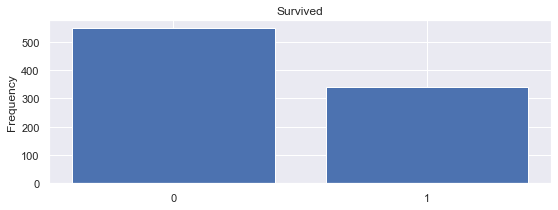

Survived: 
 0    549
1    342
Name: Survived, dtype: int64


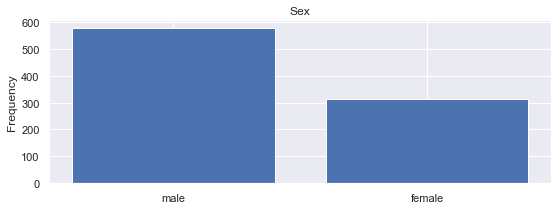

Sex: 
 male      577
female    314
Name: Sex, dtype: int64


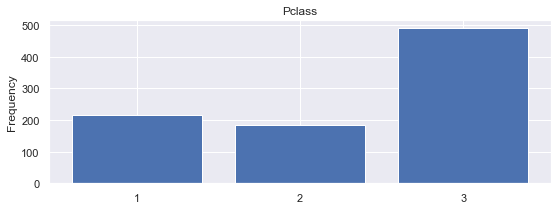

Pclass: 
 3    491
1    216
2    184
Name: Pclass, dtype: int64


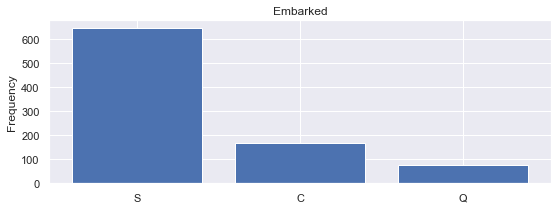

Embarked: 
 S    644
C    168
Q     77
Name: Embarked, dtype: int64


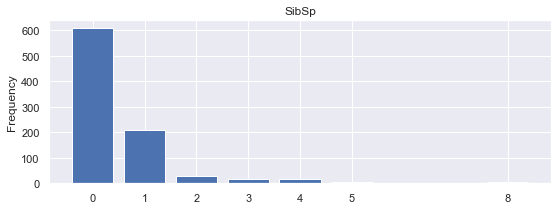

SibSp: 
 0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


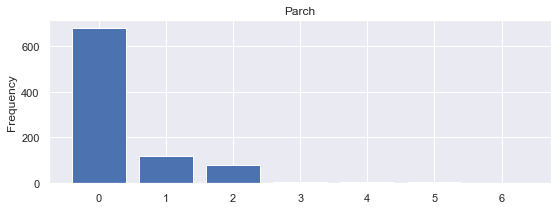

Parch: 
 0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64


In [18]:
category1 = ["Survived","Sex","Pclass","Embarked","SibSp", "Parch"]
for c in category1:
    bar_plot(c)

In [19]:
#función para graficar varibales numericas
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(df_train[variable], bins = 50)
    plt.xlabel(variable)
    plt.ylabel("Frecuancia")
    plt.title("{} Distribución".format(variable))
    plt.show()

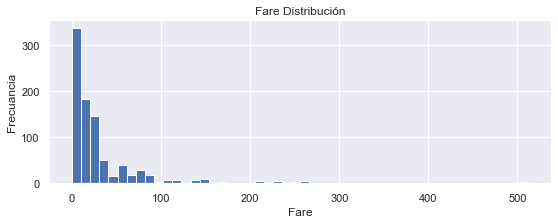

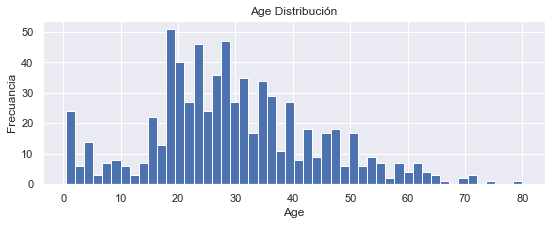

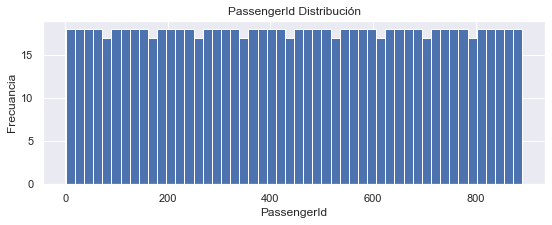

In [20]:
numericVar = ["Fare", "Age","PassengerId"]
for n in numericVar:
    plot_hist(n)

## Valores nulos

In [21]:
#valores nulos
df_train.columns[df_train.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [22]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [23]:
df_train[df_train["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


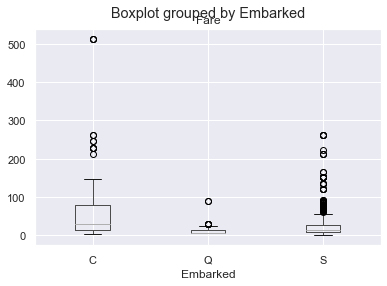

In [24]:
df_train.boxplot(column="Fare",by = "Embarked")
plt.show()

In [25]:
df_train["Embarked"] = df_train["Embarked"].fillna("C")
df_train[df_train["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [26]:
df_train[df_train["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [27]:
df_train[df_train["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


C:\Users\57313\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


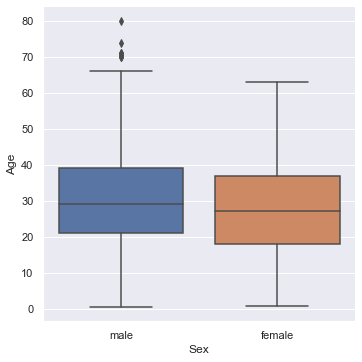

In [28]:
sns.factorplot(x = "Sex", y = "Age", data = df_train, kind = "box")
plt.show()

In [29]:
index_nan_age = list(df_train["Age"][df_train["Age"].isnull()].index)
for i in index_nan_age:
    age_pred = df_train["Age"][((df_train["SibSp"] == df_train.iloc[i]["SibSp"]) &(df_train["Parch"] == df_train.iloc[i]["Parch"])& (df_train["Pclass"] == df_train.iloc[i]["Pclass"]))].median()
    age_med = df_train["Age"].median()
    if not np.isnan(age_pred):
        df_train["Age"].iloc[i] = age_pred
    else:
        df_train["Age"].iloc[i] = age_med

C:\Users\57313\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\57313\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\57313\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [30]:
df_train[df_train["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


## Algunos preguntas a los datos

In [31]:
# Plcass vs Survived
df_train[["Pclass","Survived"]].groupby(["Pclass"], as_index = False).mean().sort_values(by="Survived",ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [32]:
# Sex vs Survived
df_train[["Sex","Survived"]].groupby(["Sex"], as_index = False).mean().sort_values(by="Survived",ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [33]:
# Parch vs Survived
df_train[["Parch","Survived"]].groupby(["Parch"], as_index = False).mean().sort_values(by="Survived",ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Algunas predicciones:
- Sexo: las mujeres tienen más probabilidades de sobrevivir.
- SibSp / Parch: Las personas que viajan solas tienen más probabilidades de sobrevivir.
- Pclass: Las personas de una clase socioeconómica más alta tienen más probabilidades de sobrevivir.

## Visualizaciones

Percentage of females who survived: 74.20382165605095
Percentage of males who survived: 18.890814558058924


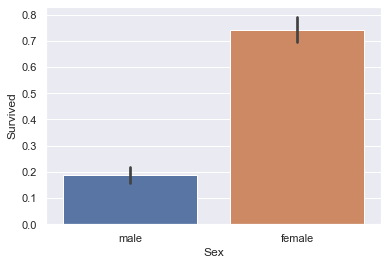

In [34]:
#dibujar un diagrama de barras de sobrevivientes por gnero
sns.barplot(x="Sex", y="Survived", data=df_train)

#imprime los porcentajes de mujeres y hombres que sobreviven
print("Percentage of females who survived:", df_train["Survived"][df_train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("Percentage of males who survived:", df_train["Survived"][df_train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

Percentage of Pclass = 1 who survived: 62.96296296296296
Percentage of Pclass = 2 who survived: 47.28260869565217
Percentage of Pclass = 3 who survived: 24.236252545824847


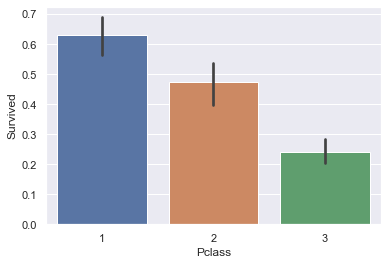

In [35]:
#dibujar diagrama de barras de sobreviviente por clase
sns.barplot(x="Pclass", y="Survived", data=df_train)

#imprimir porcentajes
print("Percentage of Pclass = 1 who survived:", df_train["Survived"][df_train["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 2 who survived:", df_train["Survived"][df_train["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 3 who survived:", df_train["Survived"][df_train["Pclass"] == 3].value_counts(normalize = True)[1]*100)

Percentage of SibSp = 0 who survived: 34.53947368421053
Percentage of SibSp = 1 who survived: 53.588516746411486
Percentage of SibSp = 2 who survived: 46.42857142857143


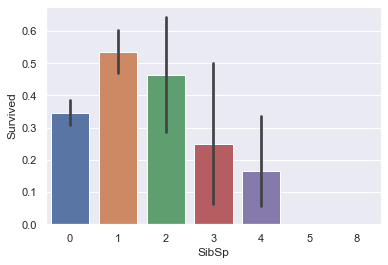

In [36]:

sns.barplot(x="SibSp", y="Survived", data=df_train)


print("Percentage of SibSp = 0 who survived:", df_train["Survived"][df_train["SibSp"] == 0].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 1 who survived:", df_train["Survived"][df_train["SibSp"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 2 who survived:", df_train["Survived"][df_train["SibSp"] == 2].value_counts(normalize = True)[1]*100)

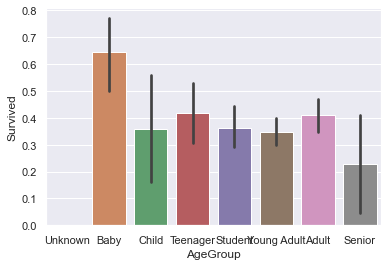

In [37]:
#ordenar las edades en categorías l
df_train["Age"] = df_train["Age"].fillna(-0.5)
df_test["Age"] = df_test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
df_train['AgeGroup'] = pd.cut(df_train["Age"], bins, labels = labels)
df_test['AgeGroup'] = pd.cut(df_test["Age"], bins, labels = labels)

#dibujar un diagrama de barras de la Edad vs la supervivencia
sns.barplot(x="AgeGroup", y="Survived", data=df_train)
plt.show()

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085


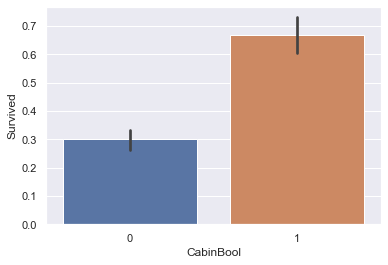

In [38]:
df_train["CabinBool"] = (df_train["Cabin"].notnull().astype('int'))
df_test["CabinBool"] = (df_test["Cabin"].notnull().astype('int'))


print("Percentage of CabinBool = 1 who survived:", df_train["Survived"][df_train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", df_train["Survived"][df_train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)

sns.barplot(x="CabinBool", y="Survived", data=df_train)
plt.show()

In [39]:
df_test.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool
count,418.000000,418.000000,418,418,418.000000,418.000000,418.000000,418,417.000000,91,418,418,418.000000
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3,8,NaN
top,NaN,NaN,"Baccos, Mr. Raffull",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S,Young Adult,NaN
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270,96,NaN
mean,1100.500000,2.265550,NaN,NaN,23.941388,0.447368,0.392344,NaN,35.627188,NaN,NaN,NaN,0.217703
std,120.810458,0.841838,NaN,NaN,17.741080,0.896760,0.981429,NaN,55.907576,NaN,NaN,NaN,0.413179
min,892.000000,1.000000,NaN,NaN,-0.500000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,996.250000,1.000000,NaN,NaN,9.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,0.000000
50%,1100.500000,3.000000,NaN,NaN,24.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,0.000000
75%,1204.750000,3.000000,NaN,NaN,35.750000,1.000000,0.000000,NaN,31.500000,NaN,NaN,NaN,0.000000


In [40]:
#eliminando el campo Cabin, ya que no se puede extraer mucha más información útil 
df_train = df_train.drop(['Cabin'], axis = 1)
df_test = df_test.drop(['Cabin'], axis = 1)

In [41]:
df_train = df_train.drop(['Ticket'], axis = 1)
df_test = df_test.drop(['Ticket'], axis = 1)

In [42]:
#now we need to fill in the missing values in the Embarked feature
print("Number of people embarking in Southampton (S):")
southampton = df_train[df_train["Embarked"] == "S"].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg (C):")
cherbourg = df_train[df_train["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown (Q):")
queenstown = df_train[df_train["Embarked"] == "Q"].shape[0]
print(queenstown)

Number of people embarking in Southampton (S):
644
Number of people embarking in Cherbourg (C):
170
Number of people embarking in Queenstown (Q):
77


In [43]:
# reemplazando los valores faltantes de Embarked con S
df_train = df_train.fillna({"Embarked": "S"})

In [44]:
#combiar los dos set de datos
combine = [df_train, df_test]

#extraer el título para cada nombre 
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [45]:
#reemplazar varios títulos con nombres más comunes
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [46]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Student,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Adult,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Young Adult,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Young Adult,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Young Adult,0,1


In [47]:
# llene la edad que falta con el grupo de edad del modo para cada título
mr_age = df_train[df_train["Title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = df_train[df_train["Title"] == 2]["AgeGroup"].mode() #Student
mrs_age = df_train[df_train["Title"] == 3]["AgeGroup"].mode() #Adult
master_age = df_train[df_train["Title"] == 4]["AgeGroup"].mode() #Baby
royal_age = df_train[df_train["Title"] == 5]["AgeGroup"].mode() #Adult
rare_age = df_train[df_train["Title"] == 6]["AgeGroup"].mode() #Adult

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}


for x in range(len(df_train["AgeGroup"])):
    if df_train["AgeGroup"][x] == "Unknown":
        df_train["AgeGroup"][x] = age_title_mapping[df_train["Title"][x]]
        
for x in range(len(df_test["AgeGroup"])):
    if df_test["AgeGroup"][x] == "Unknown":
        df_test["AgeGroup"][x] = age_title_mapping[df_test["Title"][x]]

In [48]:
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
df_train['AgeGroup'] = df_train['AgeGroup'].map(age_mapping)
df_test['AgeGroup'] = df_test['AgeGroup'].map(age_mapping)

df_train.head()


df_train = df_train.drop(['Age'], axis = 1)
df_test = df_test.drop(['Age'], axis = 1)

In [49]:
#eliminar el nombre
df_train = df_train.drop(['Name'], axis = 1)
df_test = df_test.drop(['Name'], axis = 1)

In [50]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,male,1,0,7.2500,S,4.0,0,1
1,2,1,1,female,1,0,71.2833,C,6.0,1,3
2,3,1,3,female,0,0,7.9250,S,5.0,0,2
3,4,1,1,female,1,0,53.1000,S,5.0,1,3
4,5,0,3,male,0,0,8.0500,S,5.0,0,1


In [51]:
sex_mapping = {"male": 0, "female": 1}
df_train['Sex'] = df_train['Sex'].map(sex_mapping)
df_test['Sex'] = df_test['Sex'].map(sex_mapping)

df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,1,0,7.2500,S,4.0,0,1
1,2,1,1,1,1,0,71.2833,C,6.0,1,3
2,3,1,3,1,0,0,7.9250,S,5.0,0,2
3,4,1,1,1,1,0,53.1000,S,5.0,1,3
4,5,0,3,0,0,0,8.0500,S,5.0,0,1


In [52]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,1,0,7.2500,S,4.0,0,1
1,2,1,1,1,1,0,71.2833,C,6.0,1,3
2,3,1,3,1,0,0,7.9250,S,5.0,0,2
3,4,1,1,1,1,0,53.1000,S,5.0,1,3
4,5,0,3,0,0,0,8.0500,S,5.0,0,1


In [53]:
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
df_train['Embarked'] = df_train['Embarked'].map(embarked_mapping)
df_test['Embarked'] = df_test['Embarked'].map(embarked_mapping)

df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,1,0,7.2500,1,4.0,0,1
1,2,1,1,1,1,0,71.2833,2,6.0,1,3
2,3,1,3,1,0,0,7.9250,1,5.0,0,2
3,4,1,1,1,1,0,53.1000,1,5.0,1,3
4,5,0,3,0,0,0,8.0500,1,5.0,0,1


## competencia de modelos

In [55]:
from sklearn.model_selection import train_test_split

predictors = df_train.drop(['Survived', 'PassengerId'], axis=1)
target = df_train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

In [57]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

77.66


In [59]:
# Regresión logistica
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

79.19


C:\Users\57313\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

71.57


In [61]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

78.17


C:\Users\57313\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [62]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

68.02


In [63]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

76.14


In [64]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

85.79


In [65]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

77.16


In [66]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

72.08


In [67]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

82.23


In [68]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,85.79
9,Gradient Boosting Classifier,82.23
2,Logistic Regression,79.19
6,Linear SVC,78.17
4,Naive Bayes,77.66
1,KNN,77.16
7,Decision Tree,76.14
8,Stochastic Gradient Descent,72.08
0,Support Vector Machines,71.57
5,Perceptron,68.02
